

## 1. Robustness of SIFT Keypoints to Rotation and Scaling

In [7]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from prettytable import PrettyTable 

# 检测图像关键点
def sift_detect(img):
    sift = cv2.xfeatures2d.SIFT_create()
    return sift.detect(img,None)

# 展示图像
def imshow(img, title=None, dpi=200):
    plt.figure(dpi=dpi)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.imshow(img[...,::-1])
    plt.show()

# 无裁剪的旋转
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return M,cv2.warpAffine(image, M, (nW, nH))    

# 计算经线性变换后的点
def apply_matrix(M,point):
    point = np.array([point[0],point[1],1]).T
    M = np.vstack([M,[0,0,1]])
    res = M.dot(point)
    return (int(res[0]),int(res[1]))

# 统计匹配的特征点
def count_matched_kp(kp_set,target_kp_set):
    d = [(i%3-1,j%3-1) for i in range(3) for j in range(3)]
    # d = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
    count = 0
    for i in target_kp_set:
        for j in d:
            if (i[0]+j[0],i[1]+j[1]) in kp_set:
                count+=1
                break        
    return count
    

### 1.1 Rotation

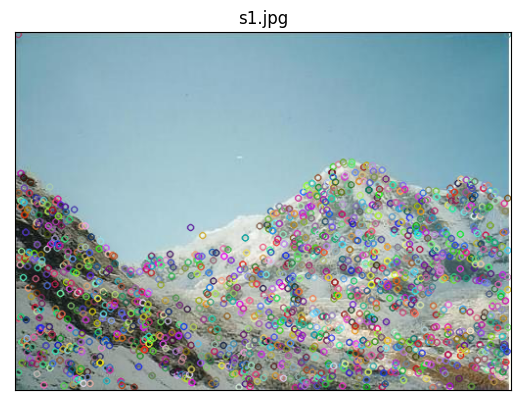

旋转变换
+----------+------------+----------+-----------+----------+
| 旋转角度 |  图片大小  | 关键点数 |  匹配点数 | 可重复性 |
+----------+------------+----------+-----------+----------+
|    0     | (366, 507) |   1353   |     /     |    /     |
|    15    | (484, 584) |   1664   |    1021   |  0.754   |
|    30    | (570, 622) |   1645   |    1033   |  0.763   |
|    45    | (617, 617) |   1684   |    1020   |  0.753   |
|    60    | (622, 570) |   1633   |    1023   |  0.756   |
|    75    | (584, 484) |   1622   |    1013   |  0.748   |
|    90    | (507, 366) |   1473   |    1088   |  0.804   |
|   105    | (584, 484) |   1658   |    1030   |  0.761   |
|   120    | (622, 570) |   1641   |    1037   |  0.766   |
|   135    | (617, 617) |   1667   |    1027   |  0.759   |
|   150    | (570, 622) |   1603   |    1032   |  0.762   |
|   165    | (484, 584) |   1631   |    1024   |  0.756   |
|   180    | (366, 507) |   1448   |    1070   |   0.79   |
|   195    | (484, 584) |   1646   |    1029   |   0.76

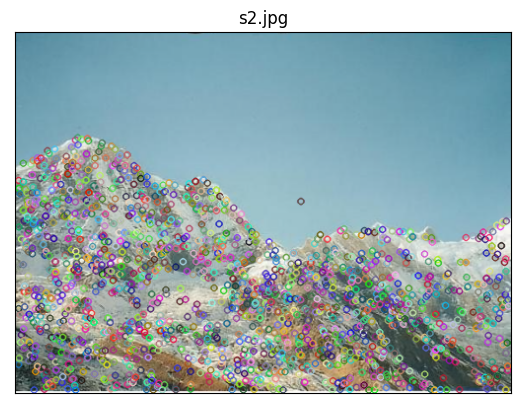

旋转变换
+----------+------------+----------+-----------+----------+
| 旋转角度 |  图片大小  | 关键点数 |  匹配点数 | 可重复性 |
+----------+------------+----------+-----------+----------+
|    0     | (366, 503) |   1431   |     /     |    /     |
|    15    | (483, 580) |   1623   |    1067   |  0.745   |
|    30    | (568, 618) |   1686   |    1093   |  0.763   |
|    45    | (614, 614) |   1701   |    1096   |  0.765   |
|    60    | (618, 568) |   1710   |    1081   |  0.755   |
|    75    | (580, 483) |   1658   |    1087   |  0.759   |
|    90    | (503, 366) |   1568   |    1143   |  0.798   |
|   105    | (580, 483) |   1646   |    1098   |  0.767   |
|   120    | (618, 568) |   1685   |    1096   |  0.765   |
|   135    | (614, 614) |   1701   |    1112   |  0.777   |
|   150    | (568, 618) |   1698   |    1109   |  0.774   |
|   165    | (483, 580) |   1661   |    1088   |   0.76   |
|   180    | (366, 503) |   1551   |    1137   |  0.794   |
|   195    | (483, 580) |   1634   |    1091   |  0.762

In [8]:

for img_path in ['s1.jpg','s2.jpg']:
    image = cv2.imread(img_path)

    kps = sift_detect(image)
    original_kp_set = {(int(i.pt[0]),int(i.pt[1])) for i in kps}
    img_kp = image.copy()
    img_kp = cv2.drawKeypoints(image,kps,img_kp)
    imshow(img_kp,title=img_path, dpi=100)

    print("旋转变换")
    table1 = PrettyTable(["旋转角度", "图片大小", "关键点数", " 匹配点数", "可重复性"])
    table1.add_row([0,image.shape[:2],len(original_kp_set),"/","/"])

    for angle in range(15,360,15):
        rM,rotated = rotate_bound(image, angle)
        target_kp_set ={apply_matrix(rM,pt) for pt in original_kp_set}
        kp = sift_detect(rotated)
        kp_set = {(int(i.pt[0]),int(i.pt[1])) for i in kp}
        matched_kp_num = count_matched_kp(kp_set,target_kp_set)
        repeataility = matched_kp_num/len(original_kp_set)
        table1.add_row([angle,rotated.shape[:2],len(kp_set),matched_kp_num,int(repeataility*1000)/1000])
        # img_kp = cv2.drawKeypoints(rotated,kp,None)
        # imshow(img_kp)
    print(table1)


由上述结果看出，SIFT 特征的可重复性对旋转变换的鲁棒性较好。

### 1.2 Scaling

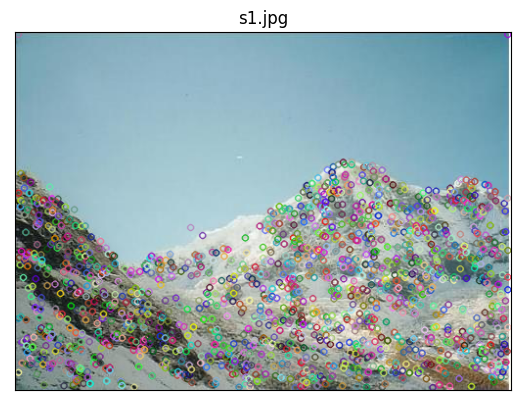

缩放变换
+----------+--------------+----------+-----------+----------+
| 缩放因子 |   图片大小   | 关键点数 |  匹配点数 | 可重复性 |
+----------+--------------+----------+-----------+----------+
|    0     |  (366, 507)  |   1353   |     /     |    /     |
|   1.2    |  (439, 608)  |   2727   |    1096   |   0.81   |
|   1.44   |  (527, 730)  |   4266   |    893    |   0.66   |
|  1.727   |  (632, 876)  |   5524   |    647    |  0.478   |
|  2.073   | (759, 1051)  |   6052   |    420    |   0.31   |
|  2.488   | (911, 1261)  |   6112   |    249    |  0.184   |
|  2.985   | (1093, 1513) |   6071   |    136    |   0.1    |
|  3.583   | (1311, 1817) |   6068   |     70    |  0.051   |
|  4.299   | (1573, 2180) |   6027   |     43    |  0.031   |
+----------+--------------+----------+-----------+----------+


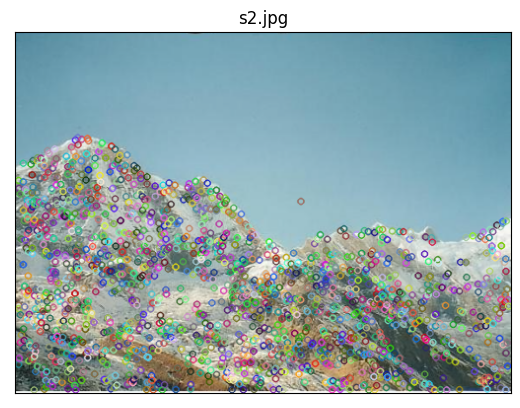

缩放变换
+----------+--------------+----------+-----------+----------+
| 缩放因子 |   图片大小   | 关键点数 |  匹配点数 | 可重复性 |
+----------+--------------+----------+-----------+----------+
|    0     |  (366, 503)  |   1431   |     /     |    /     |
|   1.2    |  (439, 604)  |   2719   |    1175   |  0.821   |
|   1.44   |  (527, 724)  |   4363   |    972    |  0.679   |
|  1.727   |  (632, 869)  |   5627   |    737    |  0.515   |
|  2.073   | (759, 1043)  |   6222   |    471    |  0.329   |
|  2.488   | (911, 1251)  |   6198   |    303    |  0.211   |
|  2.985   | (1093, 1501) |   6219   |    159    |  0.111   |
|  3.583   | (1311, 1802) |   6186   |    106    |  0.074   |
|  4.299   | (1573, 2162) |   6160   |     53    |  0.037   |
+----------+--------------+----------+-----------+----------+


In [9]:
for img_path in ['s1.jpg','s2.jpg']:
    image = cv2.imread(img_path)

    kps = sift_detect(image)
    original_kp_set = {(int(i.pt[0]),int(i.pt[1])) for i in kps}
    img_kp = cv2.drawKeypoints(image,kps,None)
    imshow(img_kp,title=img_path, dpi=100)
    
    print("缩放变换")
    table2 = PrettyTable(["缩放因子", "图片大小", "关键点数", " 匹配点数", "可重复性"])
    table2.add_row([0,image.shape[:2],len(original_kp_set),"/","/"])

    for p in range(1,9,1):
        scaling_factor = int(np.power(1.2,p)*1000)/1000
        scaled = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_CUBIC)
        sM = [[scaling_factor,0,0],[0,scaling_factor,0]]
        target_kp_set ={apply_matrix(sM,pt) for pt in original_kp_set}
        kp = sift_detect(scaled)
        kp_set = {(int(i.pt[0]),int(i.pt[1])) for i in kp}
        matched_kp_num = count_matched_kp(kp_set,target_kp_set)
        repeataility = matched_kp_num/len(original_kp_set)
        table2.add_row([scaling_factor,scaled.shape[:2],len(kp_set),matched_kp_num,int(repeataility*1000)/1000])
        # img_kp = cv2.drawKeypoints(scaled,kp,None)
        # imshow(img_kp)
    print(table2)

从以上结果可以看出，缩放变换后SIFT特征的可重复性随放大因数的增加而减少

## 2. Image mosaics

In [13]:

from PIL import Image

class Stitcher:
    # 拼接函数
    def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
        # 获取输入图片
        (imageB, imageA) = images
        print(f'images size is {images[0].shape}\n imageB size is {imageB.shape} \n imageA size is {imageA.shape}')
       
        # 检测A、B图片的SIFT关键特征点，并计算特征描述子
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # 匹配两张图片的所有特征点，返回匹配结果
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

        # 如果返回结果为空，没有匹配成功的特征点，退出算法
        if M is None:
            return None

        # 否则，提取匹配结果
        # H是3x3视角变换矩阵
        (matches, H, status) = M
        # 将图片A进行视角变换，result是变换后图片
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        #imshow(result, title='Result',dpi=200)

        # 融合
        for r in range(result.shape[0]):
            left = 0
            for c in range(result.shape[1]//2):
                if result[r,c].any(): # overlap
                    if left == 0:
                        left = c
                    alpha = (c-left)/(result.shape[1]//2-left)
                    result[r,c] = imageB[r,c]*(1-alpha) + result[r,c]*alpha
                else:
                    result[r,c] = imageB[r,c]

        # 将图片B传入result图片最左端
#         result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # 检测是否需要显示图片匹配
        if showMatches:
            # 生成匹配图片
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # 返回结果
            return (result, vis)

        # 返回匹配结果
        return result
    
    def detectAndDescribe(self, image):
        # 将彩色图片转换成灰度图
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 建立SIFT生成器
        descriptor = cv2.xfeatures2d.SIFT_create()
        # 检测SIFT特征点，并计算描述子
        (kps, features) = descriptor.detectAndCompute(gray, None)

        # 将结果转换成NumPy数组
        kps = np.float32([kp.pt for kp in kps])

        # 返回特征点集，及对应的描述特征
        return kps, features

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # 建立暴力匹配器
        matcher = cv2.DescriptorMatcher_create("BruteForce")

        # 使用KNN检测来自A、B图的SIFT特征匹配对，K=2
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

        matches = []
        for m in rawMatches:
            # 当最近距离跟次近距离的比值小于ratio值时，保留此匹配对
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                # 存储两个点在featuresA, featuresB中的索引值
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # 当筛选后的匹配对大于4时，计算视角变换矩阵
        if len(matches) > 4:
            # 获取匹配对的点坐标
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # 计算视角变换矩阵
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # 返回结果
            return (matches, H, status)

        # 如果匹配对小于4时，返回None
        return None
    
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # 初始化可视化图片，将A、B图左右连接到一起
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # 联合遍历，画出匹配对
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # 当点对匹配成功时，画到可视化图上
            if s == 1:
                # 画出匹配对
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # 返回可视化结果
        return vis


images size is (366, 507, 3)
 imageB size is (366, 507, 3) 
 imageA size is (366, 503, 3)


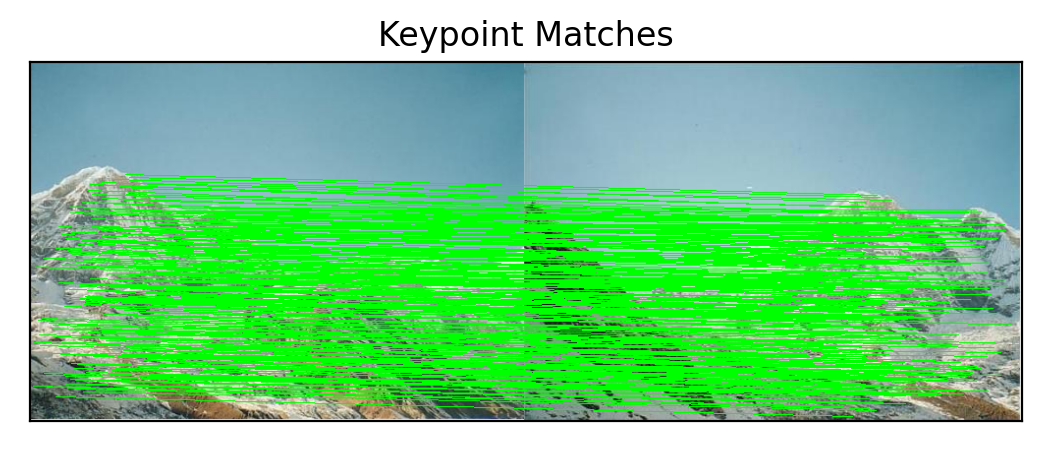

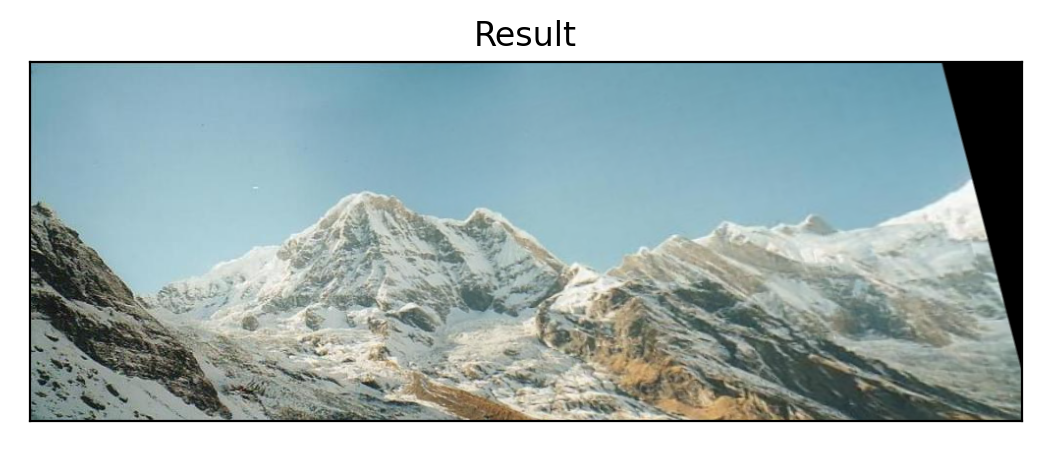

In [14]:
# 读取拼接图片
imageA = cv2.imread("s1.jpg")
imageB = cv2.imread("s2.jpg")

# 把图片拼接成全景图
stitcher = Stitcher()
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

imshow(vis,title='Keypoint Matches',dpi=200)
imshow(result, title='Result',dpi=200)



重叠部分，根据当前像素到重叠区域边缘的距离设定融合的比例，离左边越近的像素使用左图的比例越大。

images size is (366, 507, 3)
 imageB size is (366, 507, 3) 
 imageA size is (366, 503, 3)


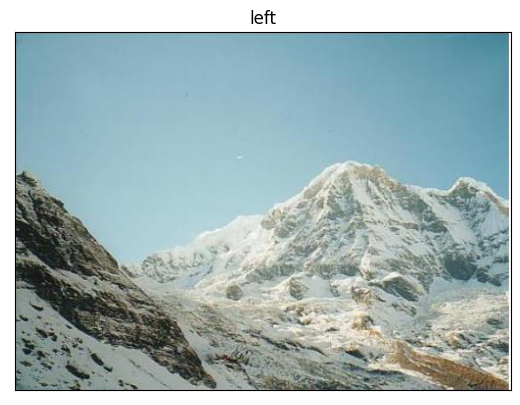

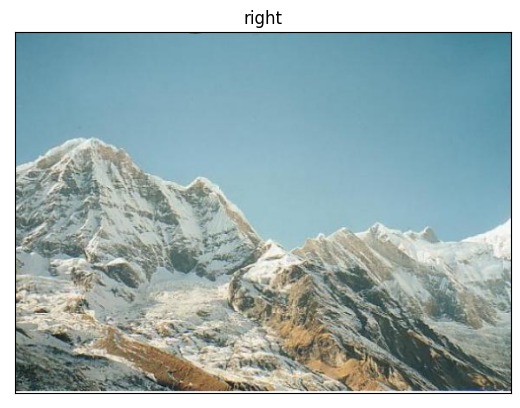

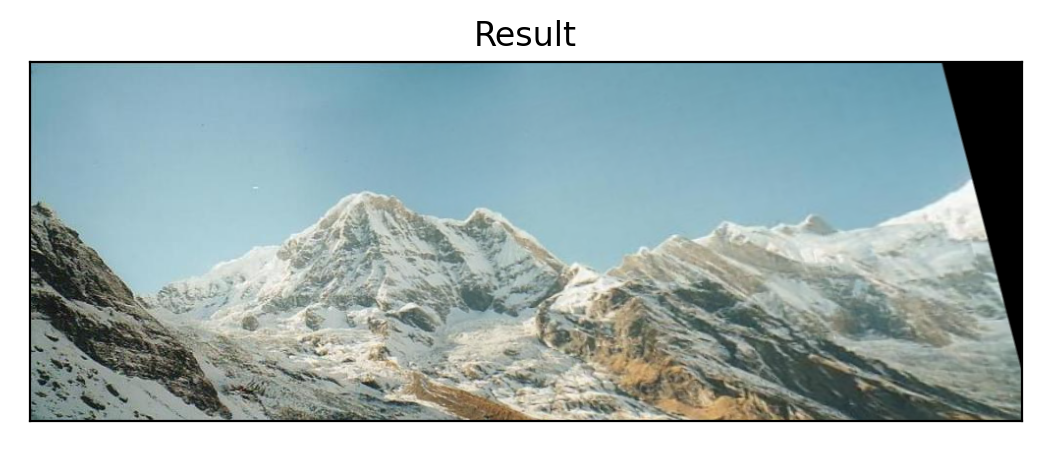

In [15]:
# 读取拼接图片
imageA = cv2.imread("s1.jpg")
imageB = cv2.imread("s2.jpg")

# 把图片拼接成全景图
stitcher = Stitcher()
result = stitcher.stitch([imageA, imageB])

imshow(imageA,title='left',dpi=100)
imshow(imageB,title='right',dpi=100)
imshow(result, title='Result',dpi=200)

In [16]:
cv2.imwrite('hhh.jpg',result)

True